# LT8306
## 1. Select the Transformer Turns Ratio

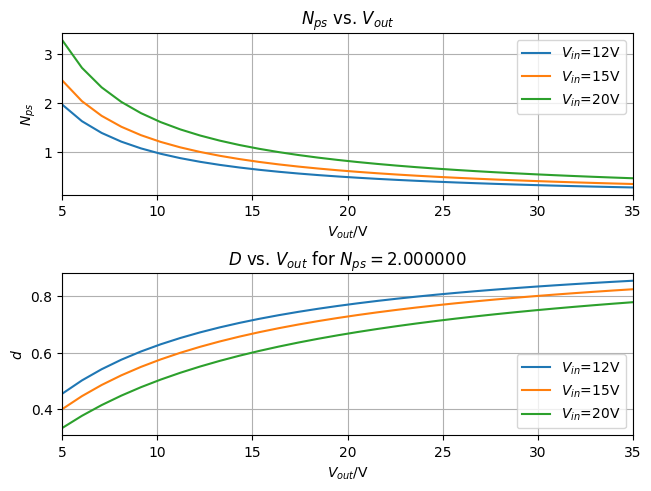

In [3]:
import numpy as np
import matplotlib.pyplot as plt

v_in = np.array([12, 15, 20]) # input voltage between 15V to 20V
v_out = np.linspace(5,35,30)
d_max = 0.45 # duty cycle, typically between 0.45 to 0.65
v_f = 0; # forward voltage (diode) --> set to zero, since LT8309 shall be used

n_ps = np.zeros((len(v_in), len(v_out)))
d = np.zeros((len(v_in), len(v_out)))

# calculate n_ps for different v_in and v_out
for i in range(len(v_in)):
    for j in range(len(v_out)):
        n_ps[i,j] = d_max * v_in[i] / ((1 - d_max) * (v_out[j] + v_f)) # primary to secondary winding ratio

# select n_ps = 1.5 for design (750311590)
n_ps_design = 2

# calucate duty cycle for fixed n_ps value
for i in range(len(v_in)):
    for j in range(len(v_out)):
        d[i,j] = ((v_out[j] + v_f)*n_ps_design)/(v_in[i] + (v_out[j] + v_f) * n_ps_design)
      
fig, ax = plt.subplots(2, 1, constrained_layout=True) # create figure

for i in range(len(v_in)):
    ax[0].plot(v_out, n_ps[i, :])
    ax[1].plot(v_out, d[i, :])

# plots
ax[0].set_title('$N_{ps}$ vs. $V_{out}$')
ax[0].legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
ax[0].set_xlabel('$V_{out}$/V')
ax[0].set_ylabel('$N_{ps}$')
ax[0].set_xlim(np.min(v_out),np.max(v_out))
ax[0].grid(True)

ax[1].set_title('$D$ vs. $V_{out}$ for $N_{ps} = %f$' % n_ps_design)
ax[1].legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
ax[1].set_xlabel('$V_{out}$/V')
ax[1].set_ylabel('$d$')
ax[1].set_xlim(np.min(v_out),np.max(v_out))
ax[1].grid(True)

## 2. Calculate $R_{sense}$ Resistor

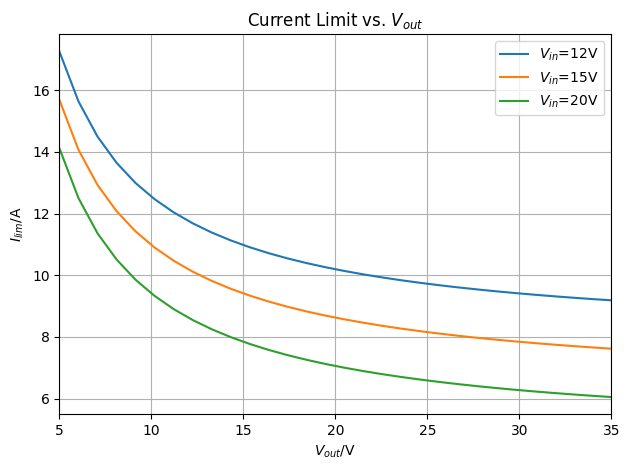

0.005277777777777778


In [9]:
pwr_max = 40 # maximum output power
eta = 0.85 # efficiency

i_lim = np.zeros((len(v_in), len(v_out)))

for i in range(len(v_in)):
    for j in range(len(v_out)):
        i_lim[i,j] = (2 * pwr_max / v_out[j]) / (eta * (1 - d[i,j]) * n_ps_design)

    plt.plot(v_out, i_lim[i,:])

plt.xlabel('$V_{out}$/V')
plt.ylabel('$I_{lim}$/A')
plt.title('Current Limit vs. $V_{out}$')
plt.legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
plt.grid(True)
plt.xlim(np.min(v_out),np.max(v_out))
plt.tight_layout()
plt.show()

i_lim_design = 18
r_sense = 95e-3 / i_lim_design

print(r_sense)

## 3. Calculate min. pri. Inductance

In [10]:
v_in_max = 20; # maximum input voltage
v_out_max = 35; # output voltage
v_f = 0.0; # forward voltage (diode) --> set to zero, since LT8309 shall be used
v_sense = 17e-3
r_sense_design = 0.002
t_demag = 440e-9; # minimum demagnetizing time
t_on = 200e-9; # minimum switch on-time

l_pri = ((v_out_max + v_f) * r_sense_design * t_demag * n_ps_design) / v_sense # minimum primary inductance 
print(l_pri)

l_pri = (v_in_max * r_sense * t_on) / v_sense
print(l_pri)

3.623529411764706e-06
1.241830065359477e-06


# 4. Select the Feedback Resistor

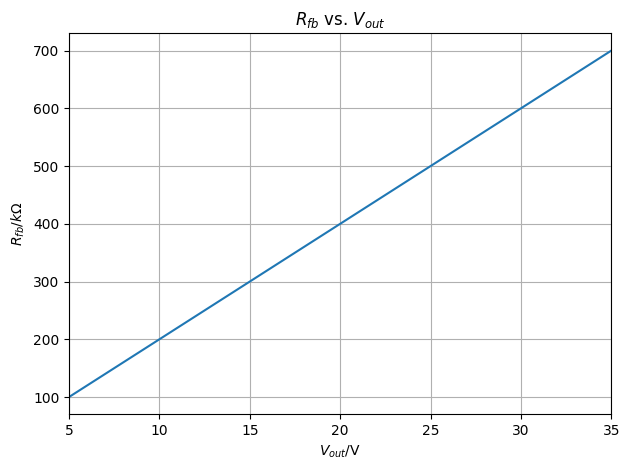

In [11]:
r_fb = n_ps_design * (v_out + v_f) / 100e-6

plt.plot(v_out, r_fb / 1e3)

plt.xlabel('$V_{out}$/V')
plt.ylabel('$R_{fb}/k\Omega$')
plt.title('$R_{fb}$ vs. $V_{out}$')
plt.xlim(np.min(v_out),np.max(v_out))
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Calculate Switching Frequency

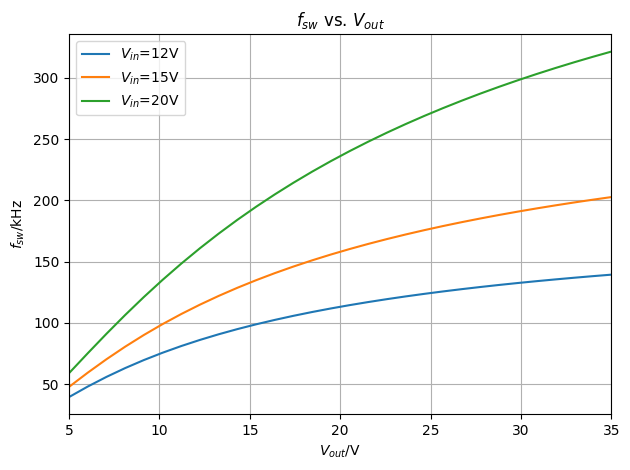

In [12]:
l_pri_design = 8e-6

f_sw = np.zeros((len(v_in), len(v_out)))

for i in range(len(v_in)):
    for j in range(len(v_out)):
        f_sw[i,j] = 1 / ( (l_pri_design * i_lim[i,j]) / v_in[i] + (l_pri_design * i_lim[i,j]) / (n_ps_design * (v_out[j] + v_f)))

    plt.plot(v_out, f_sw[i,:] / 1e3)

plt.xlabel('$V_{out}$/V')
plt.ylabel('$f_{sw}$/kHz')
plt.title('$f_{sw}$ vs. $V_{out}$')
plt.legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
plt.grid(True)
plt.xlim(np.min(v_out),np.max(v_out))
plt.tight_layout()
plt.show()

# $V_{out}$ Adjustment

The output voltage is set by changing an additional reference voltage feeding the voltage feedback network.

The output voltage can be calculated by $V_{out} = V_{FB} \cdot (1 + R_1 / R_2 + R_1 / R_3) - V_{DAC} \cdot R_1 / R_3$. 

Therefore the adjustable output voltage range is given by $\Delta V_{out} = V_{DAC,max} \cdot R_1 / R_3$.

From this equation you get: $R_1 = \frac{\Delta V_{out}}{V_{DAC,max}} \cdot R_3$.

For the output voltage range also $\Delta V_{out} = V_{out,step} \cdot \left(2^{16}-1\right)$ is valid.

If you set the lower limit to a defined voltage you get:

$V_{out,min} = V_{FB} \cdot \left(1 + R_1/R_2 + R_1/R_3 \right) - \frac{R_1 \cdot V_{DAC,max}}{R_3}$

If you solve this for $R_2$ and replace $R_1$ with the relation above you get:

$R_2 = \frac{R_3 \cdot V_{FB} \cdot  \Delta V_{out}}{V_{DAC,max} \cdot \left( \Delta V_{out} + V_{out,min} - V_{FB} \right) - V_{FB} \cdot \Delta V_{out}}$

To calculate the network correctly the following steps need to be done:

1. set $R_3$
2. calculate $R_2$ and $R_1$

maximum output voltage: 32.18181818181819
minimum output voltage: -0.318181818181813
R1: 130000.0
R2: 7150
R3: 10000.0


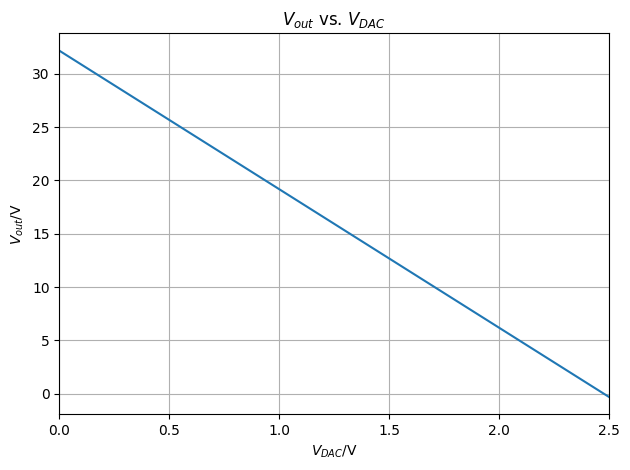

In [25]:
import numpy as np
import matplotlib.pyplot as plt

v_fb = 1
v_dac_max = 2.5 # AD5693R
v_dac = np.linspace(0, v_dac_max, np.power(2,16))

# set voltage resolution
# d_v_out = 0.5e-3 * (np.power(2,16) - 1)
d_v_out = 32.5

# set minimum voltage level
# v_out_min = -0.3838
v_out_min = -0.2

# r_1 and r_3 sets the tuneable voltage range
# set r_3
r_3 = 10e3

# calculate r_1
r_1 = (r_3 * d_v_out) / v_dac_max

# calculate r_2
# r_2 sets the "zero" point
r_2 = (r_3 * v_fb * d_v_out) / (v_dac_max * (d_v_out + v_out_min - v_fb) - v_fb * d_v_out)

# r_1 = 119365.07936507935 # (160k || 470k)
# r_2 = 6522.781774580337 # ( 6k8 || 160K)
# r_3 = 9100

r_1 = 130e3
r_2 = 7150
r_3 = 10e3

v_out = v_fb * (1 + r_1 / r_2 + r_1 / r_3) - v_dac * r_1 / r_3

print('maximum output voltage:', v_out[0])
print('minimum output voltage:', v_out[-1])

print('R1:', r_1)
print('R2:', r_2)
print('R3:', r_3)

plt.plot(v_dac, v_out)
plt.xlabel('$V_{DAC}$/V')
plt.ylabel('$V_{out}$/V')
plt.title('$V_{out}$ vs. $V_{DAC}$')
plt.grid(True)
plt.xlim(np.min(v_dac),np.max(v_dac))
plt.tight_layout()
plt.show()



# Determine Inductance

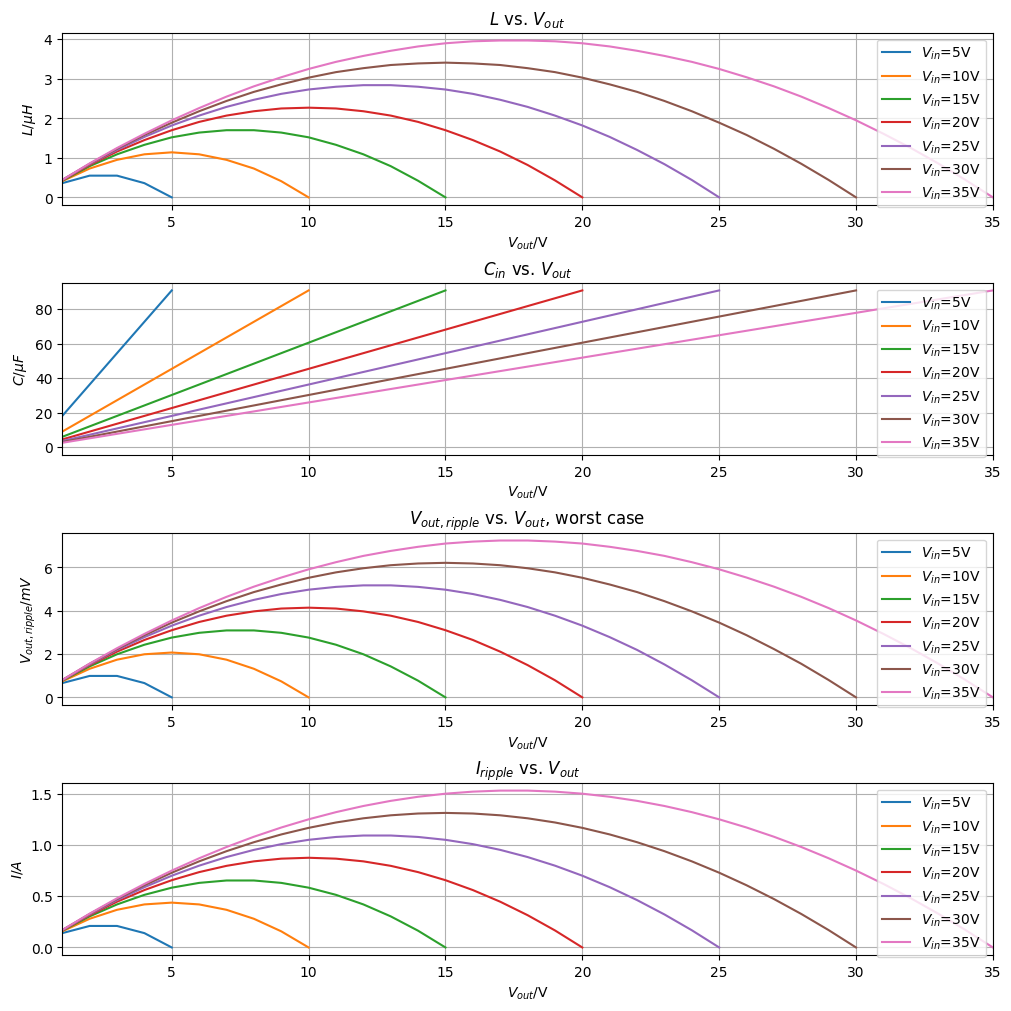

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### BASIC BUCK-REGULATOR CALCULATIONS ###
def calculate_buck_regulator_components(v_in, v_out, f_sw, i_out, di, dv_in = 100e-3, dv_out = 10e-3, l_tol = 20, c_tol = 20):
	# CALCULTE SWITCHING-PERIOD IN SEC
	t = 1 / f_sw
	# CALCULATE DUTY-CYCLE
	dc = v_out / v_in
	# CALCULATE MINIMAL INDUCTANCE
	l = ( v_out * (1 - dc) ) / ( di * f_sw )
	# CALCULATE MINIMAL INPUT CAPACITANCE
	c_in = (dc * t * i_out) / dv_in
	# CALCULATE MINIMAL OUTPUT CAPACITANCE
	c_out = ( t * di ) / ( 8 * dv_out )

	return t, dc, l, c_in, c_out

def calculate_buck_regulator_parameters(v_in, v_out, f_sw, l, i_out, c_out, c_in):
	# CALCULTE SWITCHING-PERIOD IN SEC
	t = 1 / f_sw
	# CALCULATE DUTY-CYCLE
	dc = v_out / v_in
	# CALCULATE DELTA I
	di = -( (dc - 1) * v_out ) / ( l * f_sw )
	# CALCULATE MAX. INDUCTOR CURRENT
	il_max = ( di + 2 * i_out ) / 2
	# CALCULATE INPUT VOLTAGE RIPPLE
	dv_in = ( dc * t * i_out ) / c_in
	# CALCULATE OUTPUT VOLTAGE RIPPLE
	dv_out = ( t * di ) / ( 8 * c_out )

	return t, dc, di, il_max, dv_out

f_sw = 2.2e6
i_out = 10
di = 1

v_in = np.arange(5, 36, 5)

fig, ax = plt.subplots(4, 1, constrained_layout=True, figsize=(10, 10)) # create figure

for i in range(len(v_in)):
	v_out = np.arange(0, v_in[i] + 1, 1)
	t, dc, l , c_in, c_out = calculate_buck_regulator_components(v_in[i], v_out, f_sw, i_out, di, 0.05, 5e-3)

	# print("Cout = ", np.round(c_out/1e-6,2), "uF")

	ax[0].plot(v_out, np.round(l / 1e-6,2))
	ax[1].plot(v_out, np.round(c_in / 1e-6,2))

# calculate for actual values
l = 2.6e-6
c_in = 12e-6
c_out = 12e-6

for i in range(len(v_in)):
	v_out = np.arange(1, v_in[i] + 1, 1)
	t, dc, di, il_max, dv_out = calculate_buck_regulator_parameters(v_in[i], v_out, f_sw, l, i_out, c_out, c_in)

	ax[2].plot(v_out, np.round(dv_out / 1e-3,2))
	ax[3].plot(v_out, di)

# plots
ax[0].set_title('$L$ vs. $V_{out}$')
ax[0].legend(['$V_{in}$=5V', '$V_{in}$=10V', '$V_{in}$=15V', '$V_{in}$=20V', '$V_{in}$=25V', '$V_{in}$=30V', '$V_{in}$=35V'])
ax[0].set_xlabel('$V_{out}$/V')
ax[0].set_ylabel('$L/\mu H$')
ax[0].set_xlim(np.min(v_out),np.max(v_out))
ax[0].grid(True)

ax[1].set_title('$C_{in}$ vs. $V_{out}$')
ax[1].legend(['$V_{in}$=5V', '$V_{in}$=10V', '$V_{in}$=15V', '$V_{in}$=20V', '$V_{in}$=25V', '$V_{in}$=30V', '$V_{in}$=35V'])
ax[1].set_xlabel('$V_{out}$/V')
ax[1].set_ylabel('$C/\mu F$')
ax[1].set_xlim(np.min(v_out),np.max(v_out))
ax[1].grid(True)

ax[2].set_title('$V_{out,ripple}$ vs. $V_{out}$, worst case')
ax[2].legend(['$V_{in}$=5V', '$V_{in}$=10V', '$V_{in}$=15V', '$V_{in}$=20V', '$V_{in}$=25V', '$V_{in}$=30V', '$V_{in}$=35V'])
ax[2].set_xlabel('$V_{out}$/V')
ax[2].set_ylabel('$V_{out, ripple}/mV$')
ax[2].set_xlim(np.min(v_out),np.max(v_out))
ax[2].grid(True)

ax[3].set_title('$I_{ripple}$ vs. $V_{out}$')
ax[3].legend(['$V_{in}$=5V', '$V_{in}$=10V', '$V_{in}$=15V', '$V_{in}$=20V', '$V_{in}$=25V', '$V_{in}$=30V', '$V_{in}$=35V'])
ax[3].set_xlabel('$V_{out}$/V')
ax[3].set_ylabel('$I/A$')
ax[3].set_xlim(np.min(v_out),np.max(v_out))
ax[3].grid(True)



